In [38]:
%load_ext autoreload
%autoreload 2

import gym
from matplotlib import pyplot as plt
from collections import deque
import numpy as np

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
class Actor(nn.Module):
    """Some Information about ActorCritic"""
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )

    def forward(self, x):
        return self.model(x)
    
class Critic(nn.Module):
    """Some Information about ActorCritic"""
    def __init__(self, state_size):
        super(Critic, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

class Memory:
    def __init__(self):
        self.log_probs = []
        self.values = []
        self.dones = []
        self.rewards = []
    
    def add(self, log_prob, value, done, reward):
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.dones.append(done)
        self.rewards.append(reward)
    
    def clear(self):
        self.log_probs = []
        self.values = []
        self.dones = []
        self.rewards = []
    
    def __len__(self):
        return len(self.log_probs)

In [40]:
def update(mem, next_state):
    q_values = []
    
    # Do not add this one as it's for the next state
    running_reward = critic(torch.tensor(next_state).float())
    
    for reward, done in zip(reversed(mem.rewards), reversed(mem.dones)):
        running_reward = (reward + gamma * running_reward) * (1-done)
        
        q_values.append(running_reward)
    
    q_values = torch.stack(q_values)
    values = torch.stack(mem.values)
    log_probs = torch.stack(mem.log_probs)
    
    advantage = q_values - values
    
    critic_loss = torch.pow(advantage, 2).mean()
    actor_loss = (-log_probs * advantage).sum()
    
    critic_optim.zero_grad()
    critic_loss.backward(retain_graph=True)
    critic_optim.step()
    
    actor_optim.zero_grad()
    actor_loss.backward(retain_graph=True)
    actor_optim.step()

In [41]:
env = gym.make("CartPole-v1")
# env = gym.make("LunarLander-v2")


state_space = env.observation_space.shape[0]
action_space = env.action_space.n

In [42]:
win_condition = 200

num_episodes = 500
bootstrap_len = 5

gamma = 0.99

In [43]:
mem = Memory()

actor = Actor(state_space, action_space)
critic = Critic(state_space)

actor_optim = optim.Adam(actor.parameters(), lr=1e-3)
critic_optim = optim.Adam(critic.parameters(), lr=1e-3)

In [44]:
running_scores = deque(maxlen=100)
score_log = []
average_score_log = []


t = 0
for i in range(num_episodes):
    state = env.reset()
    steps = 0
    score = 0
    
    while True:
        steps += 1
            
        value = critic(torch.tensor(state).float())
        logits = F.softmax(actor(torch.tensor(state).float()))
        
        probabilities = Categorical(logits)
        action = probabilities.sample()
        log_probs = probabilities.log_prob(action)

        next_state, reward, done, _ = env.step(action.numpy())
        score += reward

        mem.add(log_probs, value, done, reward)

        if (done or steps % bootstrap_len == 0):
            update(mem, next_state)
            mem.clear()
        
        if done:
            break
        
        state = next_state

    score_log.append(score)
    running_scores.append(score)
    average_score_log.append(np.mean(running_scores))
    
    print("\rEpisode: {:.4f}\taverage: {:.4f}\tReward: {:.4f}".format(i, np.mean(running_scores), score), end="")
    
    if i % 50 == 0:
        print("\rEpisode: {:.4f}\taverage: {:.4f}\tReward: {:.4f}".format(i, np.mean(running_scores), score))
    
    if np.mean(running_scores) > win_condition:
        print("Environment Solved!")
        break

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Episode: 0	average: 15.0	Reward: 15.0
Episode: 50	average: 22.372549019607842	Reward: 26.0
Episode: 100	average: 25.17	Reward: 22.0Reward: 21.0
Episode: 150	average: 31.19	Reward: 47.00
Episode: 200	average: 43.4	Reward: 99.000
Episode: 250	average: 46.27	Reward: 65.00
Episode: 300	average: 63.24	Reward: 71.00
Episode: 350	average: 132.96	Reward: 150.0
Episode: 400	average: 177.25	Reward: 290.0
Episode: 415	average: 202.52	Reward: 277.0Environment Solved!
Episode: 416	average: 202.69	Reward: 182.0Environment Solved!
Episode: 417	average: 202.6	Reward: 176.0Environment Solved!
Episode: 418	average: 202.89	Reward: 181.0Environment Solved!
Episode: 419	average: 202.75	Reward: 204.0Environment Solved!
Episode: 445	average: 200.78	Reward: 157.0Environment Solved!
Episode: 446	average: 201.18	Reward: 174.0Environment Solved!
Episode: 447	average: 201.82	Reward: 222.0Environment Solved!
Episode: 448	average: 204.4	Reward: 277.0Environment Solved!
Episode: 449	average: 205.51	Reward: 259.0Envi

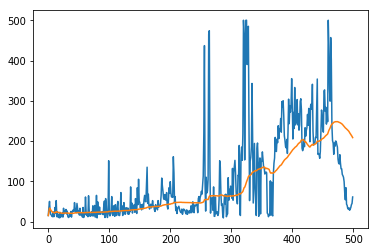

In [46]:
plt.plot(score_log)
plt.plot(average_score_log)

## Tests

In [9]:
state = env.reset()
# logits = F.softmax(actor(torch.tensor(state).float()))
# probabilities = Categorical(logits)
# action = probabilities.sample()

logits = F.softmax(actor(torch.tensor(state).float()))
probs = Categorical(logits)

log_probs = probabilities.log_prob(action)
action = probabilities.sample()

value = critic(torch.tensor(state).float())

state, reward, done, _ = env.step(action.numpy())

mem.add(log_probs, value, done, reward)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
